### Install libraries

In [17]:
!pip install dadi
!pip install pytorch-lightning

     |████████████████████████████████| 5.4 MB 4.3 MB/s 
     |████████████████████████████████| 424 kB 41.3 MB/s 
  Created wheel for dadi: filename=dadi-2.1.2-cp37-cp37m-linux_x86_64.whl size=413305 sha256=3a3c6664b78fa9159692f46df939ccd1ad3af9deb0e9ab61f33d0cd8fb8b96af
  Stored in directory: /root/.cache/pip/wheels/3a/e1/49/d822ad0ee9a61d16ca5b2b36b131c94b75515481d7ec36f9a1
Successfully built dadi
     |████████████████████████████████| 582 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 39.7 MB/s 
     |████████████████████████████████| 408 kB 47.3 MB/s 
     |████████████████████████████████| 136 kB 47.4 MB/s 
     |████████████████████████████████| 1.1 MB 38.0 MB/s 
     |████████████████████████████████| 271 kB 45.8 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 50.6 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalle

### DE part

Generate sample data using dadi 

#### 2_DivMig_5_Sim model

In [18]:
import dadi
import numpy as np


def model_func(params, ns, pts):
    """
    Simple two populations model. Ancestral population of constant size splits
    into two subpopulations of constant size with asymetrical migrations.
    :param nu1: Size of subpopulation 1 after split.
    :param nu2: Size of subpopulation 2 after split.
    :param m12: Migration rate from subpopulation 2 to subpopulation 1.
    :param m21: Migration rate from subpopulation 1 to subpopulation 2.
    :param T: Time of split.
    """

    nu1, nu2, m12, m21, T = params

    xx = dadi.Numerics.default_grid(pts)
    phi = dadi.PhiManip.phi_1D(xx)

    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    phi = dadi.Integration.two_pops(phi, xx, T, nu1=nu1, nu2=nu2, m12=m12, m21=m21)

    fs = dadi.Spectrum.from_phi(phi, ns, [xx, xx])
    return fs

In [20]:
names = np.linspace(1, 441, 441, endpoint = True, dtype = int)
a = " ".join(names.astype(str))
a += '\n'

#### Creating file with sample data, named current_file.txt

In [21]:
import dadi
import pylab

with open('/content/current_file2.txt', 'w') as f:
    f.seek(0, 2) 
    f.write(a)

n_pop = 2
pop_labels = ["Pop 1", "Pop 2"]

par_labels = ['nu1', 'nu2', 'm12', 'm21', 'T']

lower_bound = [1e-2, 1e-2, 0, 0, 1e-15]
upper_bound = [100, 100, 10, 10, 5]

mu = 2.5e-8  # mutation rate
L = 20000000  # effective length of sequence
Nanc = 10000
theta = 4 * mu * L * Nanc  # mutation flux

ns_per_pop = 20
ns = [ns_per_pop for _ in range(n_pop)]
pts_l = 20

In [ ]:
x = np.linspace(lower_bound[3], upper_bound[3], 1000, endpoint = True)

for i, u in enumerate(x):
    popt = [1, 0.1, 5, u, 0.05]
    func_ex = dadi.Numerics.make_extrap_log_func(model_func)
    model = func_ex(popt, ns, pts_l)
    data = model * theta

    data.to_file(f'/content/fs_data.txt')
    with open('/content/fs_data.txt', 'r') as f:
        for i in range(1):
            f.readline()
        x = f.readline()
        with open('/content/current_file2.txt', 'r+') as f:
            f.seek(0, 2) 
            f.write(x)

    #pylab.figure(i)
    #dadi.Plotting.plot_single_2d_sfs(data, vmin = 1)
    #pylab.savefig(f'/content/image/fs{i}.jpeg', dpi=300)

### ML part

#### Import tools

In [1]:
import pandas as pd
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as tr
from sklearn.metrics import r2_score, mean_squared_error, mean_pinball_loss
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from scipy.optimize import root
from math import sqrt, exp, sin
from matplotlib.backends.backend_pdf import PdfPages
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
#import pytorch_lightning as pl
import torch.optim as optim
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

#### Create data

- Save data to `DataFrame`

In [9]:
X = pd.read_table('/content/current_file.txt',sep='\s+', engine='python')


In [7]:
y = np.linspace(0, 10, 10000, endpoint = True)
#y = pd.DataFrame(y, index=range(y.shape[0]))

- Create train and test samples

In [10]:
X_train, X_test, y_train, y_test = tr(X, y, train_size = 0.7, random_state=500, shuffle = True)

- Create tensors for CNN

In [ ]:
y_test_tensor = torch.from_numpy(y_test)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test.reshape(3000, 21, 21))
X_train_tensor = torch.from_numpy(X_train.reshape(7000, 21, 21))

- For multioutput regression

In [55]:
k = 1000
y1 = np.array([[0.1, 5, 2.5, 0.05]]* k)
y1 = np.concatenate([[np.linspace(lower_bound[0], upper_bound[0], k, endpoint = True)], y1.T]).T
y2 = np.array([[5, 2.5, 0.05]]*k)
y2 = np.concatenate([[np.ones(k)], [np.linspace(lower_bound[1], upper_bound[1], k, endpoint = True)], y2.T]).T
y3 = np.concatenate([np.array([[1, 0.1]]* k).T, [np.linspace(lower_bound[2], upper_bound[2], k, endpoint = True)], np.array([[2.5, 0.05]]* k).T]).T
y4 = np.array([[1, 0.1, 5]]*k)
y4 = np.concatenate([y4.T, [np.linspace(lower_bound[3], upper_bound[3], k, endpoint = True)], np.array([[0.05]] * k).T]).T
y_cur2 = np.concatenate([y1, y2, y3, y4])

In [56]:
X_cur2 = pd.read_table('/content/current_file2.txt',sep='\s+', engine='python')

In [60]:
X_train2, X_test2, y_train2, y_test2 = tr(X_cur2, y_cur2, train_size = 0.7, random_state=500, shuffle = True)

### Random Forest

#### Train model

In [11]:
rfr = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=50)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=50, random_state=0)

#### Test model

In [ ]:
y_pred = rfr.predict(X_test)
print(f'For Random Forest with max_depth = {rfr.max_depth} and n_estimators = {rfr.n_estimators}:')
print(f'R2 score is equal to {r2_score(y_test, y_pred)}')
print(f'MSE score is equal to {mean_squared_error(y_test, y_pred)}')
print(f'Variance of errors is equal to {mean_squared_error(y_test, y_pred) / 3000}')
#mean_pinball_loss(y_test, y_pred)

For Random Forest with max_depth = 8 and n_estimators = 50:
R2 score is equal to 0.9999990977370584
MSE score is equal to 7.468155350707657e-06
Variance of errors is equal to 2.4893851169025523e-09


#### Choose best parameters

For choosing best parameters we used RandomizedSearchCV

In [12]:
distributions = dict(max_depth = randint(5, 10),
                     n_estimators = randint(low=10, high=100))

grid_search = RandomizedSearchCV(rfr, param_distributions = distributions, scoring='r2')

print('\n Start Grid Search')
grid_search.fit(X, y)


 Start Grid Search


RandomizedSearchCV(estimator=RandomForestRegressor(max_depth=8, n_estimators=50,
                                                   random_state=0),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbdabbb7c50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbda129a350>},
                   scoring='r2')

In [13]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized score')
print(grid_search.best_score_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 All results:
{'mean_fit_time': array([52.68689861, 46.16657119, 28.03199906, 38.50385628, 42.08063216,
        7.70518565, 34.65662947, 62.45977182, 44.060425  , 47.7232728 ]), 'std_fit_time': array([0.44404409, 0.53290464, 0.23685854, 0.46930044, 0.21322383,
       0.05660717, 0.63547442, 0.46048697, 0.61156525, 0.31785638]), 'mean_score_time': array([0.03470478, 0.02649779, 0.01870799, 0.02349873, 0.02383065,
       0.01054263, 0.02358041, 0.03441739, 0.02522588, 0.02823648]), 'std_score_time': array([0.00588109, 0.00388215, 0.00068244, 0.00288311, 0.00061708,
       0.00060239, 0.00089407, 0.00060257, 0.00111534, 0.0031924 ]), 'param_max_depth': masked_array(data=[8, 5, 5, 5, 5, 5, 8, 7, 6, 6],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[76, 88, 54, 74, 83, 15, 51, 98, 76, 84],
             mask=[False, False, False, False, Fal

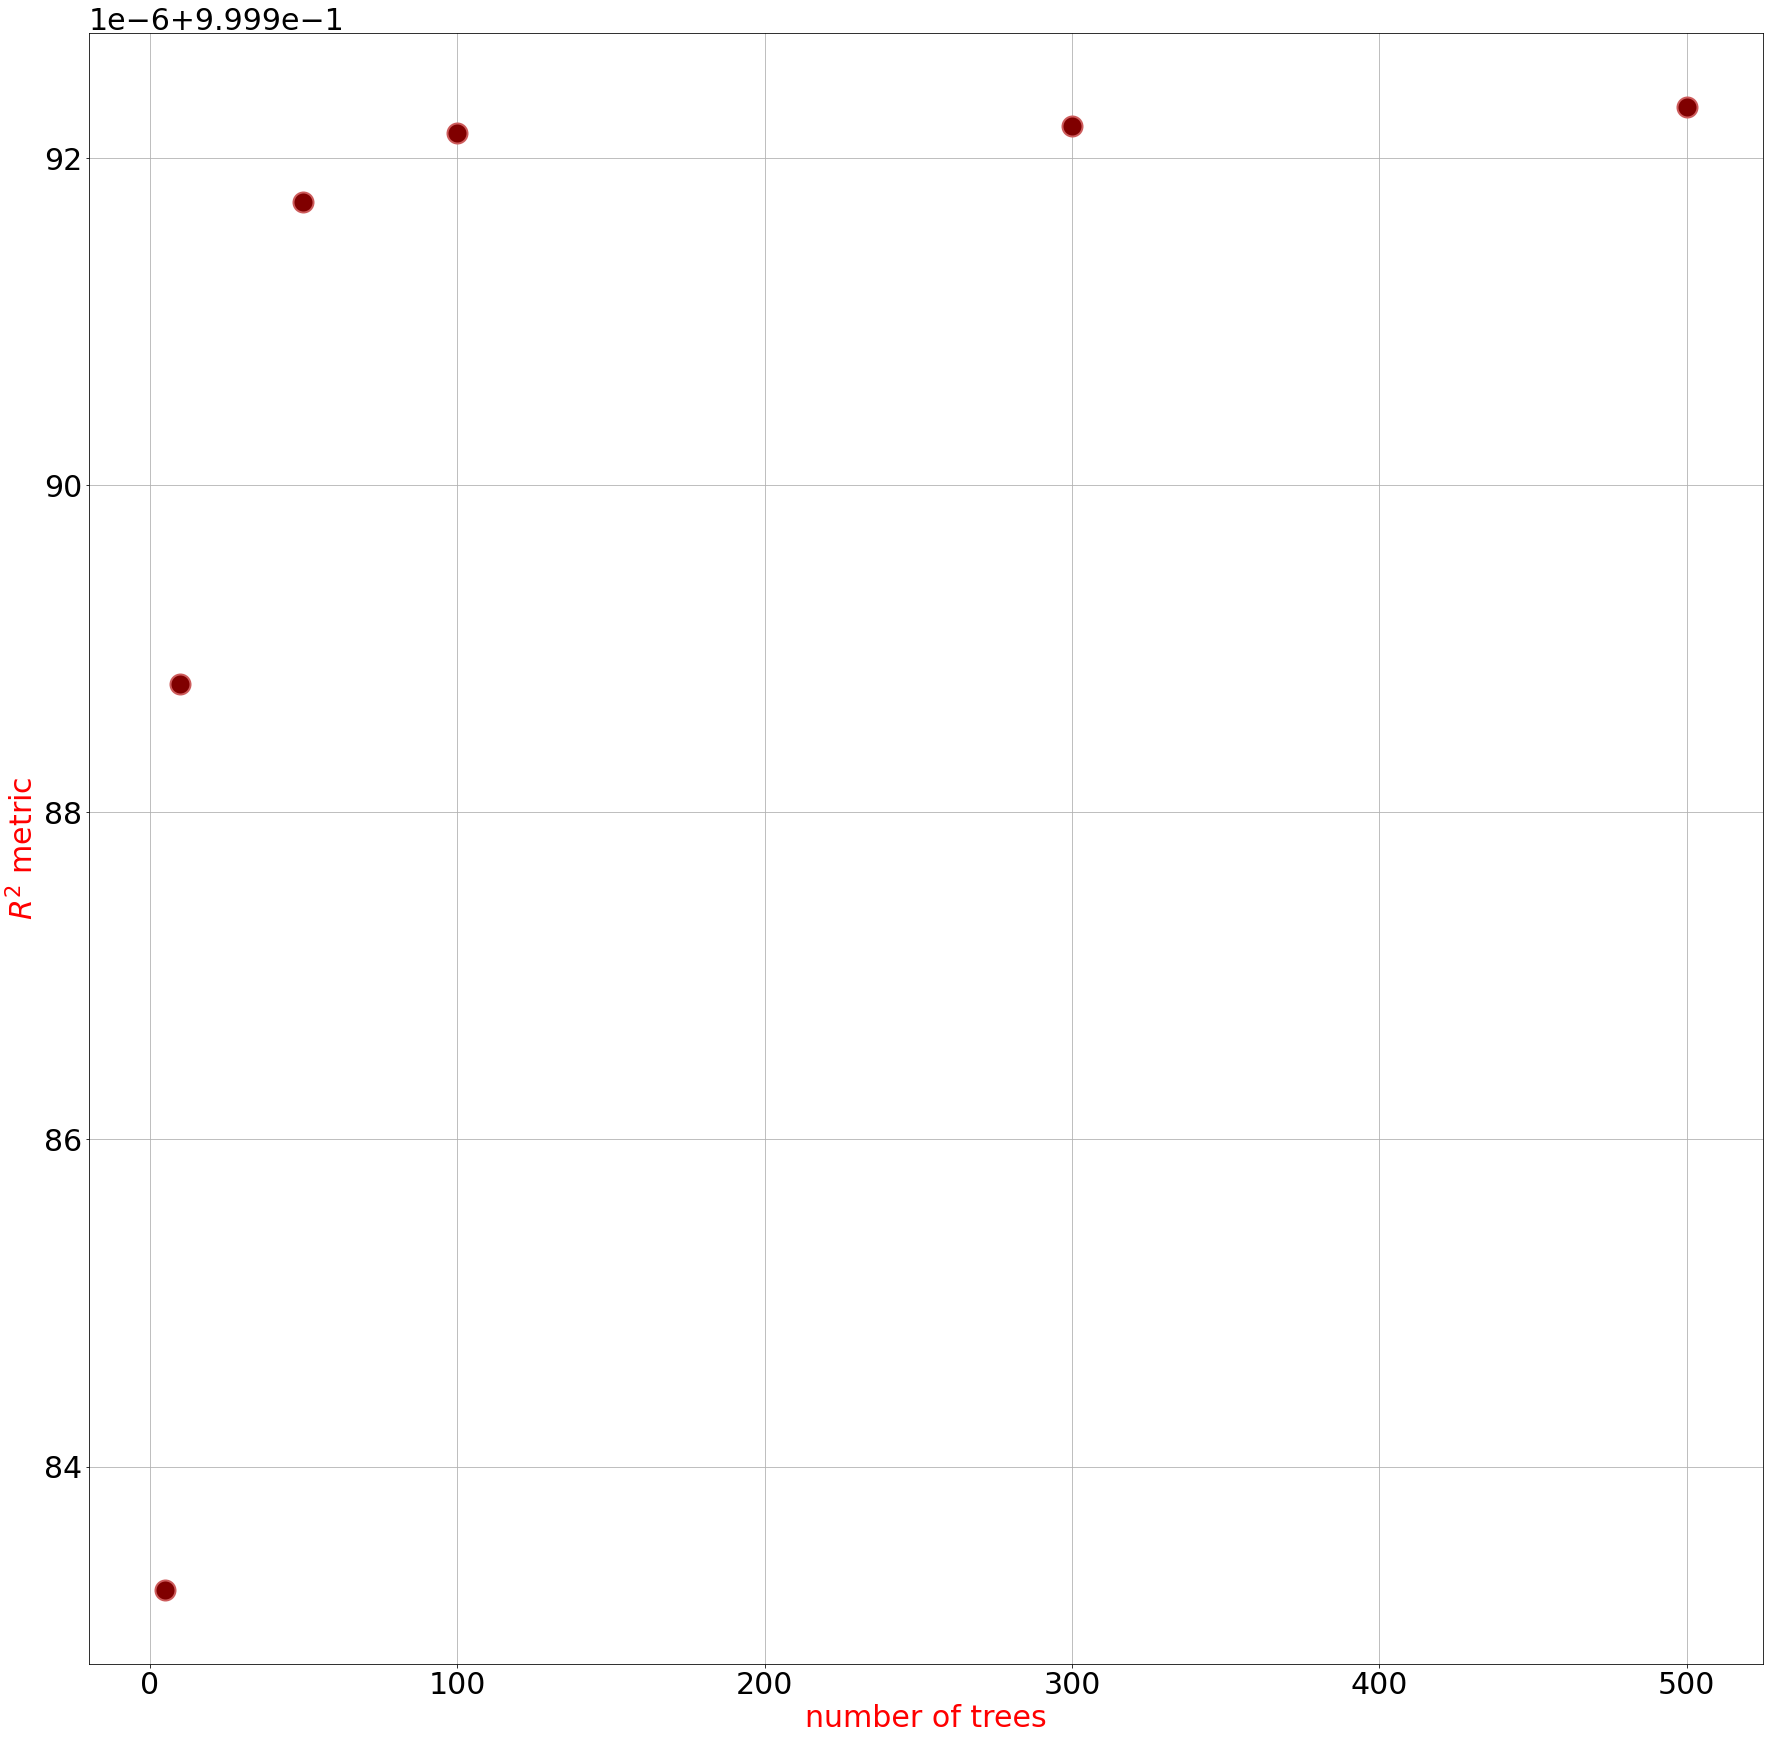

In [ ]:
def graphic(x, y, s):
    fig = plt.figure(figsize=(30, 30))
    
    plt.xlabel('number of trees', fontsize=30, color='red')
    plt.ylabel(fr'{s}', fontsize=30, color='red')
    plt.rcParams.update({'font.size': 30})
    plt.plot(x, y, color='indianred', linewidth = 0, marker = 'o', markersize = 20, markerfacecolor = 'maroon',
            markeredgecolor = 'indianred', markeredgewidth = 2)
    plt.grid(True)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.family'] = 'Calibri'
    with PdfPages(f'{s}.pdf') as pdf:
        pdf.savefig()

graphic(K, r2, s = '$R^2$ metric')

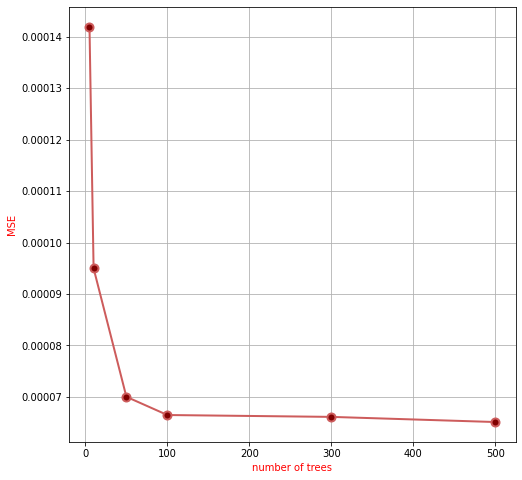

In [ ]:
graphic(K, mse, s = 'MSE')

In [14]:
rfr = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

In [15]:
y_pred = rfr.predict(X_test)
print(f'For Random Forest with max_depth = {rfr.max_depth} and n_estimators = {rfr.n_estimators}:')
print(f'R2 score is equal to {r2_score(y_test, y_pred)}')
print(f'MSE score is equal to {mean_squared_error(y_test, y_pred)}')
print(f'Variance of errors is equal to {mean_squared_error(y_test, y_pred) / 3000}')

For Random Forest with max_depth = 8 and n_estimators = 76:
R2 score is equal to 0.9999991786601288
MSE score is equal to 6.7983438878673756e-06
Variance of errors is equal to 2.266114629289125e-09


In [ ]:
ny = np.linspace(1, 300, 300, endpoint = True, dtype=int)

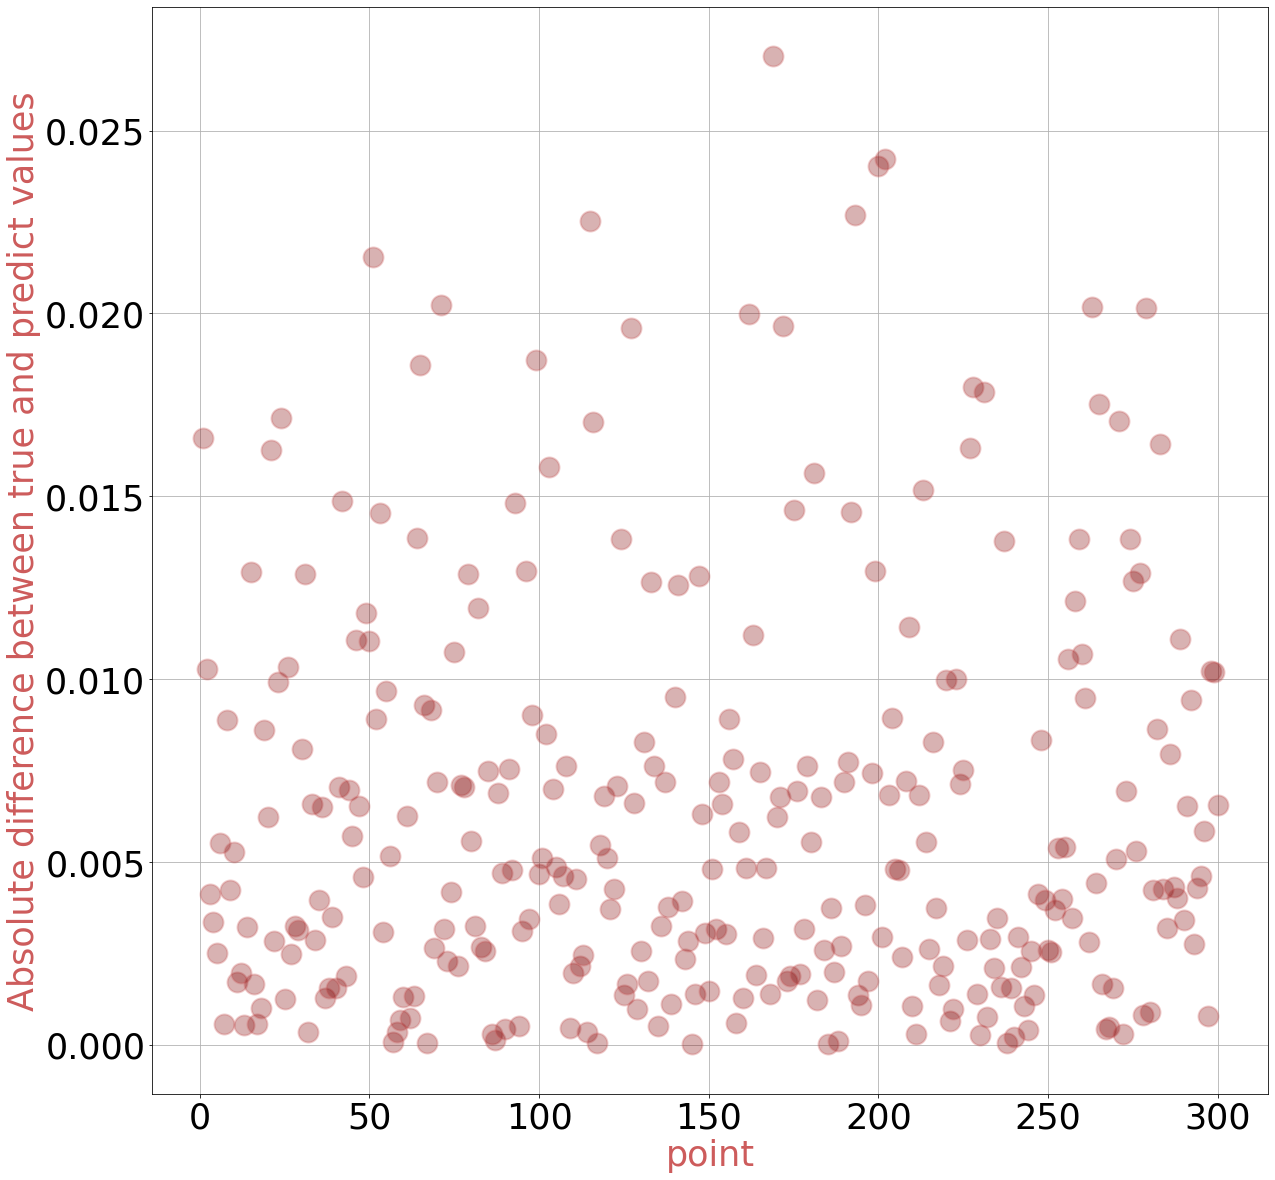

In [ ]:
def graphic_y(x, yt, yp, n):
    fig = plt.figure(figsize=(30, 15))
    
    plt.xlabel('point', fontsize=30, color='green')
    plt.ylabel(fr'parameter', fontsize=30, color='green')
    plt.rcParams.update({'font.size': 30})
    plt.plot(x, yt, color='red', linewidth = 1, marker = 'o', markersize = 15, markerfacecolor = 'maroon',
            markeredgecolor = 'indianred', markeredgewidth = 2, label = 'true', alpha = 0.3)
    plt.plot(x, yp, color='red', linewidth = 1, marker = 'o', markersize = 15, markerfacecolor = 'plum',
            markeredgecolor = 'indigo', markeredgewidth = 2, label = 'predict')
    plt.grid(True)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.family'] = 'Calibri'
    with PdfPages(f'сравнение{n}.pdf') as pdf:
        pdf.savefig()
    plt.legend()

graphic_y(ny[:50], y_test[:50], y_pred[:50], 50)

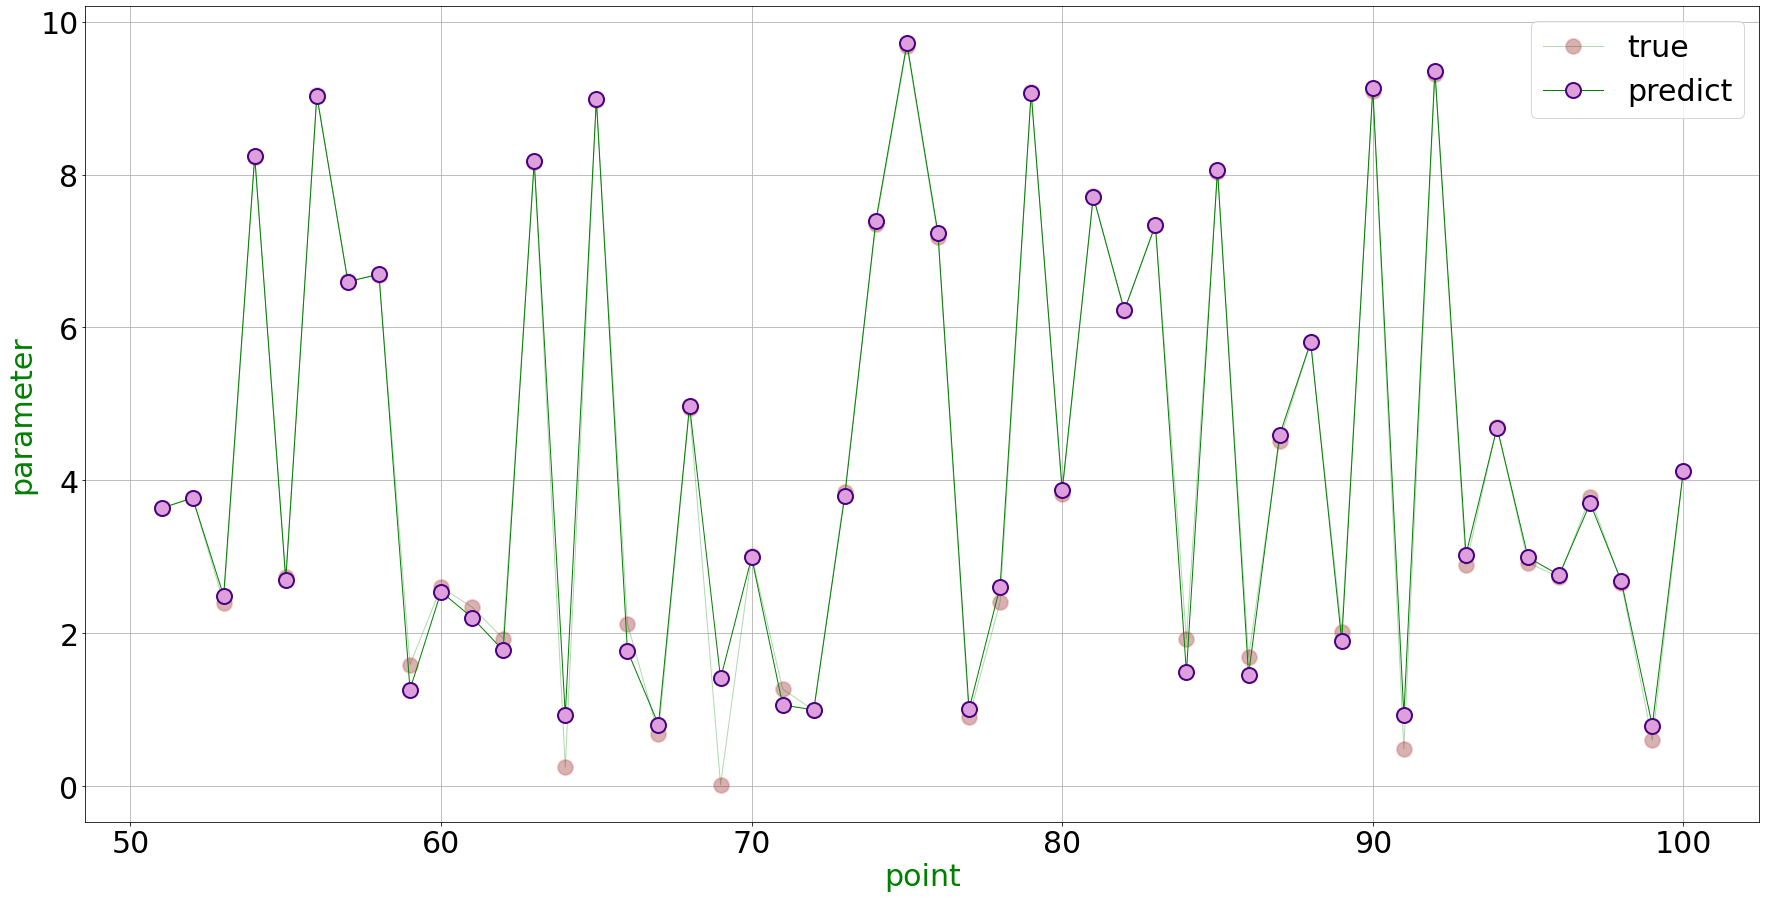

In [ ]:
graphic_y(ny[50:100], y_test[50:100], y_pred[50:100], 100)

- Predict four demographic history parameters: independent parameter prediction

In [63]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [ ]:
model = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=76)
wrapper = MultiOutputRegressor(model)
#wrapper.fit(X_cur2, y_cur2)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(wrapper, X_cur2, y_cur2, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
n_scores = np.absolute(n_scores)
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Chained multioutput regression

In [ ]:
from sklearn.multioutput import RegressorChain

In [ ]:
wrapper2 = RegressorChain(model)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(wrapper2, X_cur2, y_cur2, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
n_scores = np.absolute(n_scores)
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

### CNN

In [ ]:
IMG_SIZE = 21

class MultiLabelNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(6, 16, 3)
        self.conv4 = nn.Conv2d(16, 16, 3)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv3(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def loss_fn(self,out,target):
      return nn.functional.mse_loss(out, target)
    
    def configure_optimizers(self):
      optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
      return optimizer

    def training_step(self,batch,batch_idx):
      x, y = batch
      print('*')
      img = x.view(-1,3,IMG_SIZE,IMG_SIZE)
      label = y.view(-1)
      out = self(img)
      loss = self.loss_fn(out,label)
      self.log('train_loss', loss)
      return loss   

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

training_data = datasets.CIFAR10(
    root='data',
    train=True, 
    download=True,
    transform=transform
)

test_data = datasets.CIFAR10(
    root='data',
    train=False, 
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(training_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


#### Custom Dataset and Dataloader

In [ ]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i, :]
        data = np.asarray(data).astype(np.uint8).reshape(21, 21)
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

In [ ]:
train_data = MNISTDataset(X_train, y_train, transform)
test_data = MNISTDataset(X_test, y_test, transform)
# dataloaders
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [ ]:
model = MultiLabelNN()
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, trainloader, testloader)
#trainer.fit(model, trainloader, testloader)